In [2]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 

data_root = '/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/'
# data_dir = data_root + 'sample_images/'
data_dir = data_root + 'stage1/'
patients = os.listdir(data_dir)
patients.remove('.DS_Store')

patients.sort()
labels_df = pd.read_csv(data_root + 'stage1_labels.csv', index_col=0)
labels_df.head()

/Users/szalmaf/anaconda/envs/kaggle2017-2.7/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [3]:
type(patients)

list

In [4]:
patients[0]

'0015ceb851d7251b8f399e39779d1e7d'

In [5]:
len(patients)

1595

In [6]:
# Load the scans in given folder path
def load_CT_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [7]:
def transform_into_hounsfield_units(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

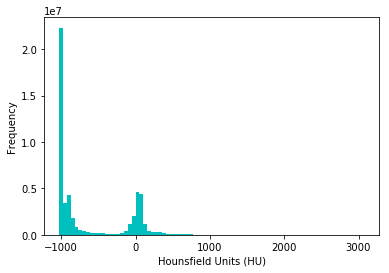

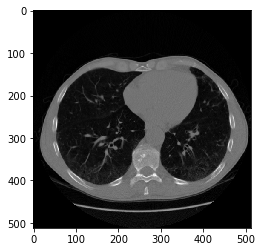

In [8]:
ct_scan = load_CT_scan(data_dir + patients[0])
ct_scan_image_HF = transform_into_hounsfield_units(ct_scan)
plt.hist(ct_scan_image_HF.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(ct_scan_image_HF[80], cmap=plt.cm.gray)
plt.show()

In [17]:
def resample_size(image, scan, new_size = [64, 244, 244]):
    
    orig_size = image.shape # size [z,x,y] (x,y or y,x??)
    zoom = np.array(new_size, dtype=np.float32)/orig_size
    
    image = scipy.ndimage.interpolation.zoom(image, zoom, mode='nearest')
    
    return image

In [10]:
new_size = [64, 244, 244]
scan = ct_scan
image = ct_scan_image_HF
orig_size = image.shape
zoom = np.array(new_size, dtype=np.float32)/orig_size
zoom, ct_scan_image_HF.shape
resample_size(ct_scan_image_HF, ct_scan)

array([ 0.32820513,  0.4765625 ,  0.4765625 ])

In [18]:
from multiprocessing import Pool
p = Pool(5)
# x = patients[1]
# ct_scan = load_CT_scan(data_dir + x)
# ct_scan_image_HF = transform_into_hounsfield_units(ct_scan)
# resample_size(ct_scan_image_HF, ct_scan, [64, 244, 244])

def fn(x):
    ct_scan = load_CT_scan(data_dir + x)
    ct_scan_image_HF = transform_into_hounsfield_units(ct_scan)
    return resample_size(ct_scan_image_HF, ct_scan, [64, 244, 244])
%time res = p.map(fn, patients[:10])

CPU times: user 90.3 ms, sys: 102 ms, total: 193 ms
Wall time: 16.4 s
